## To do

- prefer to find better term than "intermediate", as clearly gamb_colu rather than arab. 
- better colour than grey
- tidy up offsets based on new text_va logic

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import cartopy; print('cartopy', cartopy.__version__)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
import seaborn as sns
import gcsfs
from pathlib import Path
import yaml
import dask.array as da
from phase3_data import release
v3_release = release.release_data()
#cartopy text scale issues
sns.set_context('paper', font_scale=.9)

cartopy 0.17.0


### setup data

In [2]:
#samplesets
samplesets = v3_release.all_wild_samplesets

In [3]:
all_meta = v3_release.load_metadata_by_sampleset(samplesets, True)
all_meta.country = all_meta.country.str.replace("Gambia, The", "The Gambia").str.replace("Equatorial Guinea", "Bioko")

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [4]:
df_centroids = pd.read_csv("../data/Africa_centroids.csv", index_col=0).rename(str.lower, axis=1)

In [5]:
sampleset_by_country = pd.crosstab(all_meta.sampleset, all_meta.country)
# any samplesets that have multiple countries? 
sampleset_by_country.loc[(sampleset_by_country > 0).sum(axis=1) > 1]

country,Angola,Bioko,Burkina Faso,Cameroon,Central African Republic,Cote d'Ivoire,Democratic Republic of Congo,Gabon,Ghana,Guinea,Guinea-Bissau,Kenya,Malawi,Mali,Mayotte,Mozambique,Tanzania,The Gambia,Uganda
sampleset,,,,,,,,,,,,,,,,,,,
AG1000G-GN-B,0,0,0,0,0,0,0,0,0,91,0,0,0,94,0,0,0,0,0


### plotting

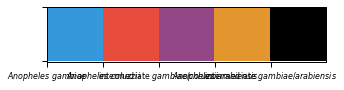

In [6]:
#countries
countries = list(all_meta.country.unique())
#long species labels
sp_nm = ['$Anopheles$ $gambiae$', '$Anopheles$ $coluzzii$',  'intermediate $gambiae$/$coluzzii$','$Anopheles$ $arabiensis$', 'intermediate $gambiae$/$arabiensis$']
#palette
flat = ["#3498db", "#e74c3c", "#944786", "#e2962d", "#000000"]
palette = sns.color_palette(flat, n_colors=len(sp_nm))
# add a colour for other_resistant
sns.palplot(palette)
plt.gca().set_xticklabels(sp_nm);

In [7]:
#build df with lat lon offsets and country labels - two letter codes?
offset_df = pd.DataFrame(index=countries, columns=["offset_lon", "offset_lat"], data=0.0)

In [8]:
offset_df.loc['Angola'] = 0, 1
offset_df.loc['Burkina Faso'] = 2, 0
offset_df.loc['Cameroon'] = -0.3, 1
offset_df.loc['Central African Republic'] = 0.3, 1
offset_df.loc["Cote d'Ivoire"] = -0.5, 0
offset_df.loc['Democratic Republic of Congo'] = 0, 3
offset_df.loc['Bioko'] = -3, -1.5
offset_df.loc['The Gambia'] = -4, 1
offset_df.loc['Ghana'] = 0.4, -1.5
offset_df.loc['Guinea-Bissau'] = -2.5, -3
offset_df.loc['Kenya'] = 0, 1
offset_df.loc['Malawi'] = -1, 0
offset_df.loc['Mali'] = 0, -1
offset_df.loc['Mayotte'] = -1, 3
offset_df.loc['Mozambique'] = 1, -2
offset_df.loc['Tanzania'] = 0, 1
offset_df.loc['Uganda'] = 0, 1

In [9]:
alternate_names = {
#     "Equatorial Guinea": "Bioko",
#     "Gambia, The": "The Gambia",
    "Central African Republic": "Central African Republic".replace(" ", "\n"),
    "Democratic Republic of Congo": "Democratic\nRepublic\nof Congo",
    "Mayotte":"Mayotte island".replace(" ", "\n"),
    "Bioko": "Bioko island".replace(" ", "\n"),
    "Cote d'Ivoire": "Cote d'Ivoire".replace(" ", "\n"),
    "The Gambia": "The Gambia".replace(" ", "\n")
}

In [10]:
label_locations = {
    c: "bottom" for c in ['Ghana', 'Guinea-Bissau', 'Gabon', 'Bioko', 'Kenya', 'Angola', 'Tanzania', 'Malawi', 'Mozambique', 'Burkina Faso', 'Democratic Republic of Congo', "Cote d'Ivoire"]}
label_locations

{'Ghana': 'bottom',
 'Guinea-Bissau': 'bottom',
 'Gabon': 'bottom',
 'Bioko': 'bottom',
 'Kenya': 'bottom',
 'Angola': 'bottom',
 'Tanzania': 'bottom',
 'Malawi': 'bottom',
 'Mozambique': 'bottom',
 'Burkina Faso': 'bottom',
 'Democratic Republic of Congo': 'bottom',
 "Cote d'Ivoire": 'bottom'}

In [11]:
arab_call = pd.crosstab(all_meta.country, all_meta.species_gambcolu_arabiensis)
colu_call = pd.crosstab(all_meta.country, all_meta.species_gambiae_coluzzii)
colu_call.rename({"intermediate": "gambaie/coluzzii"}, axis=1, inplace=True)

In [12]:
summary_counts = pd.concat([arab_call, colu_call], axis=1, sort=False).fillna(0).astype(int)
summary_counts.drop("gamb_colu", axis=1, inplace=True)

In [13]:
summary_counts.head()

,arabiensis,intermediate,coluzzii,gambiae,gambaie/coluzzii
Angola,0,0,81,0,0
Bioko,0,0,0,10,0
Burkina Faso,3,0,135,157,1
Cameroon,2,0,26,416,0
Central African Republic,0,0,18,55,0


In [14]:
ar, it, cl, ga, gc = summary_counts.loc["Uganda"]
ar, it, cl, ga, gc

(82, 1, 0, 207, 0)

In [15]:
#code to get a single averaged lat/lon and species composition for each country
def plot_pyr_map(dpi=150, extent=[-23, 48, -20, 17.5], figsize=(8, 4), label_fontsize=7):
    
    subplot_kw = dict(projection=ccrs.PlateCarree())
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw, dpi=dpi)
    ax.add_feature(cfeature.LAND, linewidth=1, zorder=1)
    ax.coastlines(resolution='50m', linewidth=0.7, zorder=2)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=5)
    
    for c in countries:
        
        ar, it, cl, gm, gc = summary_counts.loc[c]
        
        #use centroids for countries +- offsets
        offset_lon = offset_df.loc[c].offset_lon
        offset_lat = offset_df.loc[c].offset_lat
        
        lon = df_centroids.loc[c].longitude
        lat = df_centroids.loc[c].latitude

        centre = (lon + offset_lon, lat + offset_lat)
        radius = np.sqrt(summary_counts.loc[c].sum() * .02)
        text_offset = (radius + (0.1 * radius))
        
        ax.add_patch(plt.Circle(xy=centre, radius=radius, facecolor='none', edgecolor='k', zorder=8, lw=1))
        ax.pie([gm, cl, gc, ar, it], wedgeprops=dict(zorder=7), colors=palette, center=centre, radius=radius, shadow=True)
        
        # assume we want label above the pie unless otherwise specified
        # if we want the text to appear _below_ the pie- we need to:
        # substract radius etc (text_offset)
        # set the text vertical alignment to "top"
        
        # otherwise... 
        # the vertical offset should be positive
        # the va should be "bottom"
        
        text_pos = label_locations.get(c, "top")
        text_va = "bottom"
        
        # text_va is therefore bottom if top, and top if bottom.
        if text_pos == "bottom":
            text_va = "top"
            text_offset = -text_offset
        
        long_label = alternate_names.get(c, c)
        
        ax.text(
            centre[0], 
            centre[1] + text_offset, 
            long_label, 
            ha='center', 
            va=text_va,
            fontsize=6, 
            fontweight='bold', 
            bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=.8, ), 
            zorder=6)
        
        # plot a line if there is an offset
        if offset_lat != 0 or offset_lon != 0:
            ax.plot([lon, lon + offset_lon],[lat, lat + offset_lat], 'k-', lw=1, zorder=5)
            
        
   # manual colour legend
    plt.text(-14.0, -1.3, 'Species', fontsize=7,fontweight='bold')
    
    plt.plot([-17.5, -20.6],[-3.9, -3.9], color=flat[0], lw=7, zorder=20, solid_capstyle='round')
    plt.text(-15.5,-4.5,  sp_nm[0], fontsize=7 )

    plt.plot([-17.5, -20.6],[-6.4, -6.4], color=flat[1], lw=7, zorder=20, solid_capstyle='round')
    plt.text(-15.5,-7, sp_nm[1], fontsize=7 )
    
    plt.plot([-17.5, -20.6],[-9.0, -9.0], color=flat[2], lw=7, zorder=20, solid_capstyle='round')
    plt.text(-15.5,-9.55, sp_nm[2], fontsize=7 )
    
    plt.plot([-17.5, -20.6],[-11.6, -11.6], color=flat[3], lw=7, zorder=20, solid_capstyle='round')
    plt.text(-15.5,-12.1, sp_nm[3], fontsize=7 )
    
    plt.text(-17,-16.5, '   Sample size', fontsize=7,fontweight='bold')
    #cover tiny islands
    plt.plot([-17, -15],[-6.5, -6.5], 'w', lw=20, zorder=3)
    plt.plot([-6.5, -6],[-15, -15], 'w', lw=20, zorder=3)      

    #X0,X1,Y0,Y1  extent format  
    ax.set_extent(extent) 
    
    #size legend
    l1 = Line2D([], [], marker = 'o', markersize=11, markerfacecolor='k',  color='w') 
    l2 = Line2D([], [], marker = 'o', markersize=20, markerfacecolor='k',  color='w') 
    l3 = Line2D([], [], marker = 'o', markersize=32, markerfacecolor='k',  color='w')
    labelz = ["n=50", " n=150", "   n=300"]   
    leg = ax.legend([l1, l2, l3], labelz, ncol=3, frameon=False, fontsize=7,handlelength=2.1, loc = 3,
                     borderpad = 1.6, handletextpad=0.6, bbox_to_anchor=(-0.025, 0.0))
    # If format is not set, then the output format is inferred from the extension of fname, if any, and from rcParams["savefig.format"] = 'png' otherwise.
    fig.savefig('../content/artwork/collection_map.svg', dpi=dpi, bbox_inches='tight');
    return ax

/opt/conda/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/conda/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/conda/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


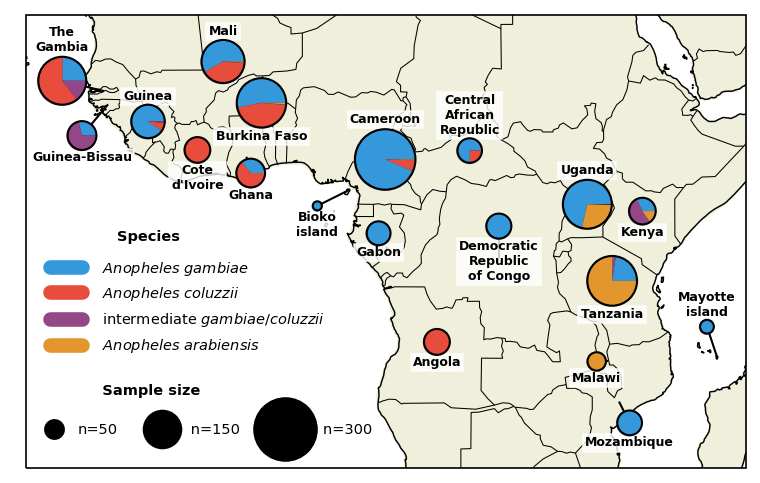

In [16]:
a = plot_pyr_map()